### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

12>4,14>12,1>2,0>1,3>5,15>9,2>6,7>3,5>0,12>15,14>8,10>7,11>13,9>11,6>14|13:10>7>3>5>0>1>2>6>14>12>15>9>11>13


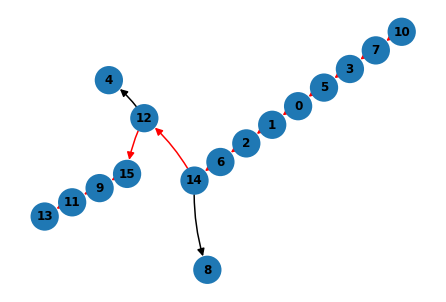

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

Loading contents from file...


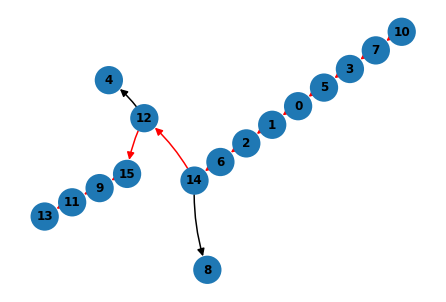

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 13>2,3>6,0>14,15>0,15>8,13>7,9>13,3>10,2>4,12>11,11>15,11>1,5>3,14>5,2>12|6:9
Completion: >13>2>12>11>15>0>14>5>3>6

Prompt: 7>6,3>14,6>0,4>12,1>5,9>7,1>8,12>1,14>13,0>4,2>15,8>3,15>10,2>11,10>9|13:2
Completion: >15>10>9>7>6>0>4>12>1>8>3>14>13

Prompt: 14>5,14>9,13>14,6>3,3>15,10>12,1>11,2>1,9>7,0>4,7>6,15>2,8>0,4>13,15>10|11:8
Completion: >0>4>13>14>9>7>6>3>15>2>1>11

Prompt: 5>0,9>12,7>14,4>11,0>6,3>1,9>13,5>7,10>5,1>10,10>15,2>8,3>9,0>4,1>2|6:3
Completion: >1>10>5>0>6

Prompt: 6>11,1>10,3>1,1>4,5>6,2>14,2>8,12>3,14>15,8>7,8>12,10>13,7>9,12>0,3>5|4:2
Completion: >8>12>3>1>4

Prompt: 9>14,15>0,12>11,11>1,8>2,14>4,15>3,0>12,5>9,8>10,1>6,7>13,14>7,11>8,2>5|4:15
Completion: >0>12>11>8>2>5>9>14>4

Prompt: 2>15,10>2,13>3,5>6,12>1,15>11,3>14,6>0,11>12,7>4,1>7,9>13,8>9,0>10,14>5|4:8
Completion: >9>13>3>14>5>6>0>10>2>15>11>12>1>7>4

Prompt: 12>15,5>7,1>3,9>10,10>12,6>13,2>8,8>11,10>14,6>0,3>4,0>1,3>5,8>9,1>2|13:6
Completion: >13

Prompt: 6>7,0>2,12>6,8>10,14>12,10>4,15>11,7>5,10>0,11>

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)

# Load in the model if weights are in the directory, else train new model
if os.path.exists("model_legacy.pt"):
    model.load_state_dict(torch.load("model_legacy.pt"))
    """
    model.load_and_process_state_dict(torch.load("model_legacy.pt"),        
                                        fold_ln=True,
                                        center_writing_weights= True,
                                        center_unembed = True,
                                        fold_value_biases=True,
                                        refactor_factored_attn_matrices=False
                                    )
    """
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model_legacy.pt")

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["random", "backward", "forward"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1
      else:
        pred, _ = eval_model(model, dataset, graph)
        plt.show()

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

random: 99.7000%
backward: 98.9000%
forward: 100.0000%


0>9,8>0,5>8,5>4,6>10,6>5,3>13,2>6,7>3,7>2,12>7,11>12,11>1,15>11,14>15|9:14>15>11>12>7>2>6>5>8>0>9


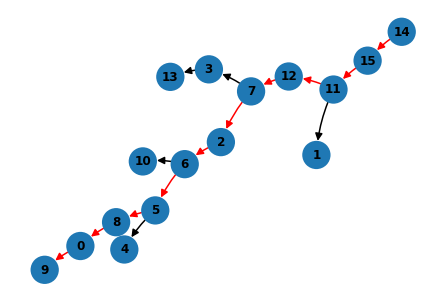

In [7]:
random_seed = np.random.randint(400_000, 600_000)
test_graph = generate_example(n_states, random_seed, order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

0>1,1>2,2>3,3>4,4>5,5>6,6>7,0>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|7:0>1>2>3>4>5>6>7


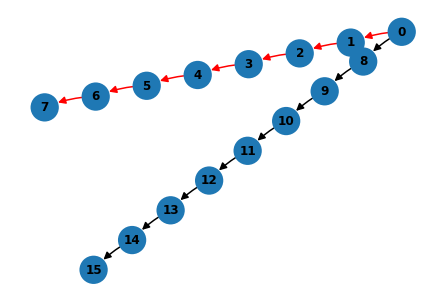

In [8]:
test_graph = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,0>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|7:0>1>2>3>4>5>6>7"
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [9]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

In [10]:
layer = 2
[dataset.idx2tokens[x] for x in ( cache[f"blocks.{layer}.attn.hook_z"][0, 47:, 0, :] @ model.blocks[layer].attn.W_O[0] @ model.W_U ).argmax(-1)]

['>5',
 '>5',
 '>5',
 '>5',
 '>5',
 '>5',
 '>6',
 '>7',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',',
 ',']

In [11]:
model.blocks[0].attn.W_O.shape

torch.Size([1, 128, 128])

In [12]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_in', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out

### Attention: QK Circuit Visualization

In [13]:
QK = model.blocks[0].attn.W_Q[0] @ model.blocks[0].attn.W_K[0].T

In [14]:
def get_att_score(q, k):
    return (model.W_pos[q:q+1] @ QK @ model.W_pos[k:k+1].T)[0,0]

In [15]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for i in range(model.cfg.n_ctx):
    for j in range(model.cfg.n_ctx):
        scores[i, j] = get_att_score(i, j)


In [16]:
scores = torch.zeros(model.cfg.n_ctx, model.cfg.n_ctx)
for q in range(model.cfg.n_ctx):
    for k in range(model.cfg.n_ctx):
        
        q_out = model.W_pos[q:q+1] @ model.blocks[0].attn.W_Q[0] # + model.blocks[0].attn.b_Q
        k_out = model.W_pos[k:k+1] @ model.blocks[0].attn.W_K[0] + model.blocks[0].attn.b_K
        
        scores[q, k] = q_out @ k_out.T

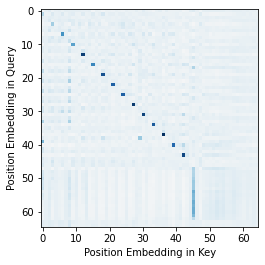

In [17]:
plt.imshow(scores.softmax(dim=1).detach(), cmap="RdBu", vmin=-0.2, vmax=0.2)
plt.ylabel("Position Embedding in Query")
plt.xlabel("Position Embedding in Key")

plt.savefig('filename.png', dpi=300)


In [18]:
QK_1 = model.blocks[1].attn.W_Q[0] @ model.blocks[1].attn.W_K[0].T

In [19]:
model.W_E.norm(dim=-1)

tensor([0.7581, 0.7163, 1.0437, 1.5364, 1.5295, 1.5519, 1.5195, 1.5677, 1.5168,
        1.5394, 1.5509, 1.5278, 1.4542, 1.5005, 1.5393, 1.5379, 1.6050, 1.5504,
        1.5246, 1.2416, 1.1501, 1.1448, 1.2536, 1.2186, 1.2808, 1.2593, 1.1483,
        1.1358, 1.2406, 1.1408, 1.1666, 1.2143, 1.2139, 1.2035, 1.1767],
       device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

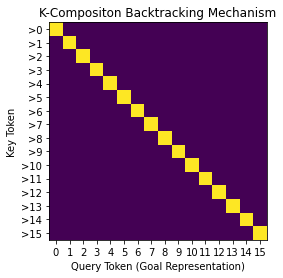

In [20]:
scores2 = torch.zeros(16, 16)
for i in range(16):
    goal_rep = model.W_E[dataset.tokens2idx[str(i)]][None, :] #+ model.W_pos[45:46]
    v1 = goal_rep @ model.blocks[0].attn.W_V[0] # + model.blocks[0].attn.b_V
    o1 = v1 @ model.blocks[0].attn.W_O[0]  + model.blocks[0].attn.b_O
    
    
    o1 = model.blocks[0].ln2(o1)
    o1 = o1 + model.blocks[0].mlp(o1[None, :])[0]

    for j in range(16):
        key = model.W_E[dataset.tokens2idx[">"+str(j)]][None, :] @ model.blocks[1].attn.W_K[0] # + model.blocks[1].attn.b_K
        query = o1 @ model.blocks[1].attn.W_Q[0] #+ model.blocks[1].attn.b_Q
        scores2[i, j] = query @ key.T


plt.imshow((scores2).softmax(-1).detach())
plt.title("K-Compositon Backtracking Mechanism")

plt.xticks(list(range(16)), [str(i) for i in range(16)])
plt.yticks(list(range(16)), [">" + str(i) for i in range(16)])

plt.xlabel("Query Token (Goal Representation)")
plt.ylabel("Key Token")

plt.savefig('filename.png', dpi=300)


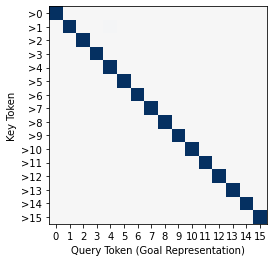

In [21]:
scores2 = torch.zeros(16, 16)
for i in range(16):
    goal_rep = model.W_E[dataset.tokens2idx[str(i)]][None, :] #+ model.W_pos[45:46]
    v1 = goal_rep @ model.blocks[0].attn.W_V[0] # + model.blocks[0].attn.b_V
    o1 = v1 @ model.blocks[0].attn.W_O[0]  + model.blocks[0].attn.b_O
    
    o1 = model.blocks[0].ln2(o1)
    o1 = o1 + model.blocks[0].mlp(o1[None, :])[0]

    for j in range(16):
        key = model.W_E[dataset.tokens2idx[">"+str(j)]][None, :] @ model.blocks[1].attn.W_K[0] # + model.blocks[1].attn.b_K
        query = o1 @ model.blocks[1].attn.W_Q[0] #+ model.blocks[1].attn.b_Q
        scores2[i, j] = query @ key.T


plt.imshow((scores2).softmax(-1).detach(), cmap="RdBu", vmin=-0.2, vmax=0.2)

plt.xticks(list(range(16)), [str(i) for i in range(16)])
plt.yticks(list(range(16)), [">" + str(i) for i in range(16)])

plt.xlabel("Query Token (Goal Representation)")
plt.ylabel("Key Token")

plt.savefig('filename.png', dpi=300)


### Experiment: Logit Lens

In [22]:
test_graph = generate_example(n_states, 1231, order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)

In [23]:
logit_lens(pred, model, dataset)

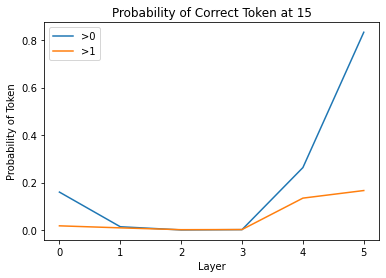

{'>0': [0.1597956269979477,
  0.01373339630663395,
  0.0003700406232383102,
  0.0015713406028226018,
  0.2631295323371887,
  0.8334488272666931],
 '>1': [0.017589140683412552,
  0.00904854852706194,
  0.0013187009608373046,
  0.0019334879470989108,
  0.1343642920255661,
  0.16633643209934235]}

In [24]:
logit_lens_all_probs(pred, model, dataset, 47)

In [25]:
lenses = calculate_tuned_lens(model, dataset)   


0.21992351921648465
0.2510522985501664
0.3438746595504691
0.4829156235384742
0.7551927150678148
0.9999587333901896


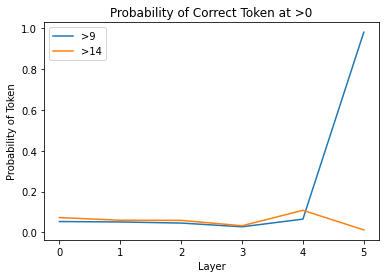

{'>9': [0.05359310656785965,
  0.051441438496112823,
  0.04613245278596878,
  0.027836402878165245,
  0.06536464393138885,
  0.9808608293533325],
 '>14': [0.07290187478065491,
  0.05988684296607971,
  0.059291161596775055,
  0.03284203261137009,
  0.10851774364709854,
  0.012520580552518368]}

In [26]:
logit_lens_all_probs(pred, model, dataset, 48, lenses=lenses)

In [27]:
logit_lens(pred, model, dataset, lenses=lenses)

### Get LogitLens Decision-Level plots

In [28]:
def logit_lens_get_depth(pred, model, dataset, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    return [ (np.array(outs).T.tolist()[1+i], labels[48+i]) for i in range(end-47-1)]

logit_lens_get_depth(pred, model, dataset, lenses=lenses)


[(['>8', '>8', '>7', '>10', '>0', '>0'], '>0'),
 (['>8', '>11', '>7', '>10', '>3', '>9'], '>9'),
 (['>8', '>11', '>7', '>10', '>1', '>12'], '>12'),
 (['>8', '>8', '>7', '>10', '>1', '>1'], '>1'),
 (['>8', '>8', '>7', '>10', '>2', '>2'], '>2'),
 (['>8', '>8', '>7', '>10', '>3', '>3'], '>3'),
 (['>8', '>8', '>7', '>10', '>10', '>10'], '>10'),
 (['>8', '>8', '>11', '>7', '>7', '>7'], '>7'),
 (['>8', '>8', '>11', '>8', '>11', '>11'], '>11'),
 (['>8', '>8', '>8', '>8', '>8', '>8'], '>8')]

In [29]:
from collections import defaultdict

solved_depth_dict = defaultdict(lambda: [])


for _ in range(200_000, 210_000):
    
    test_graph = generate_example(n_states, _, order="backward")
    pred, correct = eval_model(model, dataset, test_graph)
    if not correct:
        continue

    positions = logit_lens_get_depth(pred, model, dataset, lenses=lenses)

    for i, (tuned_ans, answer) in enumerate(positions[::-1]):
        try:
            solved_depth = tuned_ans.index(answer)+1
            solved_depth_dict[i+1].append(solved_depth)
        except:
            print(_)
            print(tuned_ans, answer)


200441
['>0', '>14', '>15', '>9', '>3', '>3'] >6
200515
['>14', '>12', '>6', '>4', '>11', '>9'] >15
200527
['>3', '>14', '>9', '>4', '>6', '>8'] >11
200675
['>4', '>11', '>13', '>9', '>6', '>7'] >1
201185
['>4', '>3', '>6', '>7', '>5', '>10'] >1
201388
['>12', '>2', '>15', '>11', '>13', '>14'] >7
201765
['>14', '>7', '>6', '>10', '>0', '>0'] >2
202146
['>7', '>7', '>12', '>14', '>4', '>6'] >2
202213
['>7', '>7', '>11', '>1', '>14', '>14'] >3
202290
['>13', '>13', '>5', '>6', '>0', '>4'] >10
202356
['>13', '>3', '>3', '>8', '>5', '>10'] >4
203249
['>2', '>2', '>1', '>13', '>13', '>10'] >12
203769
['>15', '>0', '>5', '>10', '>11', '>8'] >4
204206
['>8', '>1', '>15', '>9', '>5', '>4'] >6
204522
[',', '>10', '>5', '>14', '>9', '>2'] >11
204880
['>10', '>5', '>5', '>12', '>6', '>4'] >9
205545
['>7', '>12', '>10', '>11', '>13', '>2'] >9
205670
['>6', '>7', '>5', '>12', '>1', '>4'] >11
206108
['>9', '>0', '>5', '>15', '>15', '>7'] >2
206199
['>6', '>3', '>13', '>2', '>1', '>9'] >0
206356
['>4

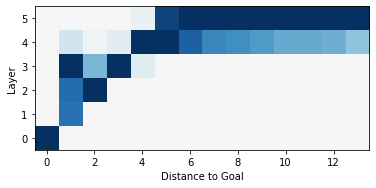

In [30]:
solved_depth_matrix = torch.zeros(len(solved_depth_dict.keys()), 6)
for key in solved_depth_dict:
    for val in solved_depth_dict[key]:
        solved_depth_matrix[key-1, val-1] += 1

normed = solved_depth_matrix / solved_depth_matrix.max(-1).values[:, None]

plt.imshow(
    normed[:-1].T,
    cmap="RdBu", vmin=-1.0, vmax=1.0, origin='lower')


plt.xlabel("Distance to Goal")
plt.ylabel("Layer")

plt.savefig('filename.png', dpi=300)



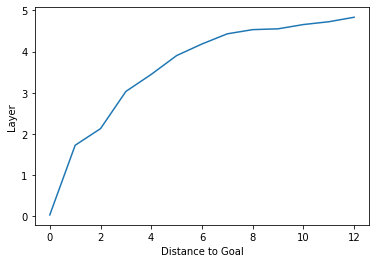

In [53]:
plt.plot([np.array(solved_depth_dict[i]).mean() -1 for i in range(1, 14)])
plt.yticks(list(range(6)))


plt.xlabel("Distance to Goal")
plt.ylabel("Layer")

plt.savefig('filename.png', dpi=300)


(array([  10.,    0., 2401.,    0., 1302.,    0.,  850.,    0.,  112.,
           3.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

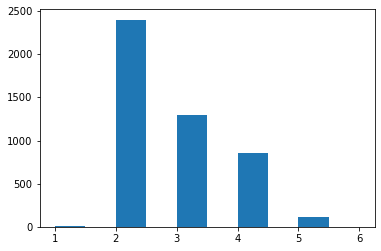

In [64]:
plt.hist(solved_depth_dict[2])

In [39]:
solved_depth_dict[0]

[]

### Experiment: Attention Blockout ACDC

In [ ]:
model.reset_hooks()
parse_example(test_graph)

In [ ]:
ablated_edges, important_edges = attention_knockout_discovery(model, dataset, test_graph)

In [ ]:
model.reset_hooks()

for L in ablated_edges.keys():
    inds = ablated_edges[L]
    if len(inds) == 0:
        continue
    add_attention_blockout_parallel(model, L, inds)

pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)

In [ ]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


In [ ]:
G = nx.DiGraph()

for pos, label in enumerate(labels):
    for layer in range(model.cfg.n_layers+1):
        G.add_node(f"{label}_{pos}_{layer}", layer=layer)

for L in important_edges.keys():
    for h, curr, attend in important_edges[L]:
        G.add_edge(f"{labels[attend]}_{attend}_{L}", f"{labels[curr]}_{curr}_{L+1}")


# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots(figsize=(20, 25))
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

### Experiment: Looking at Embeddings

In [ ]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

### Experiment: Probing


In [17]:
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=1_024
)

for key in X.keys():
   tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0], 0] for x in X[key] ]
   X[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

In [18]:
from sklearn import preprocessing
y = {"incoming": [], "outgoing": []}

for graph in graphs:
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])

y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

In [19]:
for xkey in X.keys():    
    for ykey in y.keys():
        score = linear_probing(X[xkey], y[ykey])
        print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")

Layer 0 incoming node probe - 1.000
Layer 0 outgoing node probe - 0.083
Layer 1 incoming node probe - 1.000
Layer 1 outgoing node probe - 1.000
Layer 2 incoming node probe - 1.000
Layer 2 outgoing node probe - 1.000
Layer 3 incoming node probe - 1.000
Layer 3 outgoing node probe - 1.000
Layer 4 incoming node probe - 1.000
Layer 4 outgoing node probe - 1.000
Layer 5 incoming node probe - 1.000
Layer 5 outgoing node probe - 1.000


In [22]:
scores = []

for xkey in X.keys():    
    score = linear_probing(X[xkey], y["incoming"])
    print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")


plt.plot(scores)
plt.title("Performance of Linear Probes on Extracting Information from")
plt.xlabel("Layer")
plt.ylabel("F1 Score of Probe on Value Vectors")
plt.show()

dict_keys(['incoming', 'outgoing'])

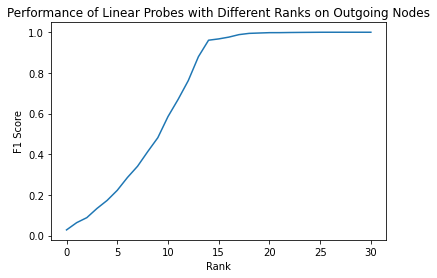

In [20]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["outgoing"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Outgoing Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

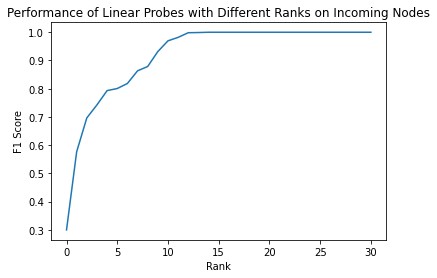

In [21]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["incoming"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Incoming Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

### Experiment: Low Rank Approximation of Attention

In [ ]:
from functools import partial


def add_low_rank_hook(layer, k):
    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X[utils.get_act_name("v", layer, "attn")])

    # Add low-rank hook
    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre

    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()
n_pca = 20

add_low_rank_hook(3, n_pca)
add_low_rank_hook(4, n_pca)
add_low_rank_hook(5, n_pca)

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

### Experiment: Activation Patching

In [ ]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

In [ ]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


In [ ]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [ ]:
patchings[index][0]